<a href="https://colab.research.google.com/github/aksesss/PIS/blob/master/hw/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 2

#### Загрузка датасета

In [0]:
!pip install tensorflow-gpu

In [0]:
import numpy as np
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

In [0]:
#@title
def load_data_from_np(folder_path, classes = None, verbose = 1):
  '''
  Загрузит множество npy файлов и объединит. (X, y)

  Parameters:
    
    folder_path (string): Путь до директории с файлами (Заканчивается именем папки)

    classes (list[string]): Названия классов, которые необходимо загружать
          Если None то загрузит все

    verbose (int): Если 1 то выводит логи. 0 - иначе
  '''
  X, y = None, []
  start_time = time.time()

  for file_path in glob.glob(folder_path + '/*.*'):
    class_name = file_path.split('/')[-1].split('.')[0]
    if ((classes == None) or (class_name in classes)):
      if (X is None):
        X = np.load(file_path)
        y = np.array([class_name]*X.shape[0])
      else:
        X_temp = np.load(file_path)
        X = np.concatenate((X, X_temp))
        y = np.concatenate((y, np.array([class_name]*X_temp.shape[0])))
      
      if (verbose == 1):
        #print('{} loaded. Total time {}'.format(class_name, time.time() - start_time))
        print('%-25s Total time: %-4f'%(class_name, time.time() - start_time))
  print('\nDone')
  return (X, np.array(y))

In [0]:
GLOBAL_PATH = '/content/drive/My Drive/Colab Notebooks/hw'
n_classes = 8

In [6]:
X, y = load_data_from_np(GLOBAL_PATH + '/data/np_images/train')

homer                     Total time: 2.132552
bart_simpson              Total time: 7.096500
abraham_grampa_simpson    Total time: 9.775021
fat_tony                  Total time: 10.424265
krusty_the_clown          Total time: 12.689672
marge_simpson             Total time: 13.737742
maggie_simpson            Total time: 14.815986
lisa_simpson              Total time: 17.697570

Done


#### Преобразуем датасет

In [0]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

ohe = OneHotEncoder(sparse=False)
y = ohe.fit_transform(y.reshape(-1, 1))
map_characters = {i : ohe.categories_[0][i] for i in range(7) }


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True)

#### Изобразим наши данные

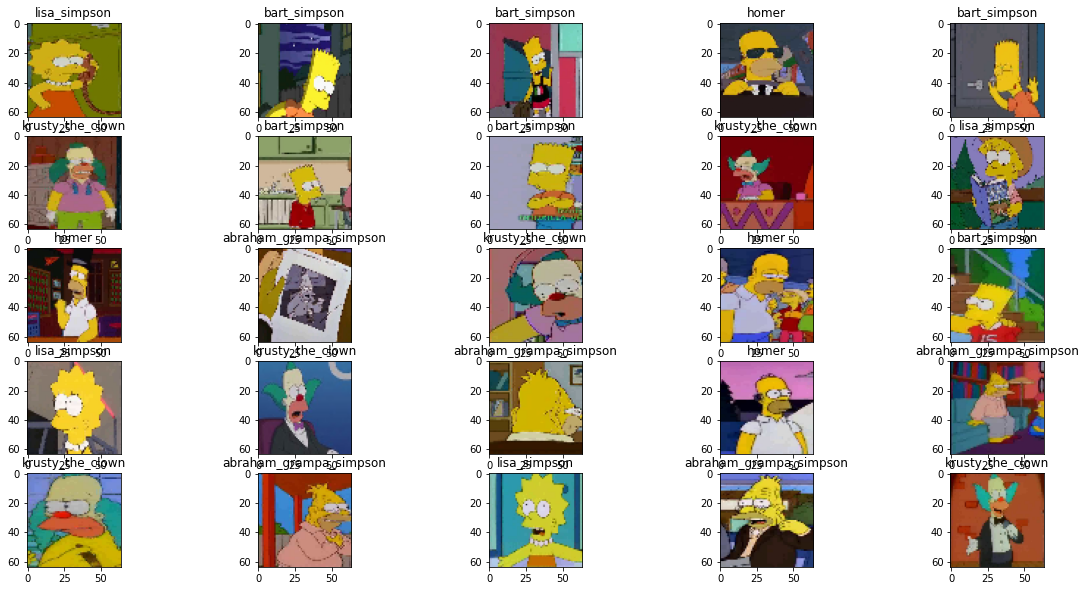

In [9]:
plt.figure(figsize=(20,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    n = np.random.choice(X.shape[0])
    
    plt.imshow(X[n])
    #plt.title(ohe.inverse_transform(y[n].reshape(1, -1))[0][0])
    plt.title(map_characters[np.argmax(y[n])])

#### Загрузка предобученной модели

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam

def create_model_six_conv(input_shape):
    """
    CNN Keras model with 6 convolutions.
    :param input_shape: input shape, generally X_train.shape[1:]
    :return: Keras model, RMS prop optimizer
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) 
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(18, activation='softmax'))
    opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    return model, opt

def load_model_from_checkpoint(weights_path, input_shape=(64,64,3)):
    model, opt = create_model_six_conv(input_shape)
    model.load_weights(weights_path)
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model

Using TensorFlow backend.


In [11]:
%time pretrained_model = load_model_from_checkpoint(GLOBAL_PATH + '/data/weights.best.hdf5')

CPU times: user 376 ms, sys: 107 ms, total: 483 ms
Wall time: 17.2 s


#### Уберем полносвязные слои и добавим свои

In [0]:
model = Sequential()

for l in pretrained_model.layers[:-3]:
  model.add(l)

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

In [0]:
opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=opt,
          metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)       

#### Создадим генератор изображений для тренировочного датасета

- Поскольку в некоторых классах слишком мало данных, применим ImageDataGenerator

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen_train = ImageDataGenerator(
                    rotation_range=20,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.3
                    )

data_train_gen = image_gen_train.flow(X_train, y_train)

#### Изобразим работу датагенератора

In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

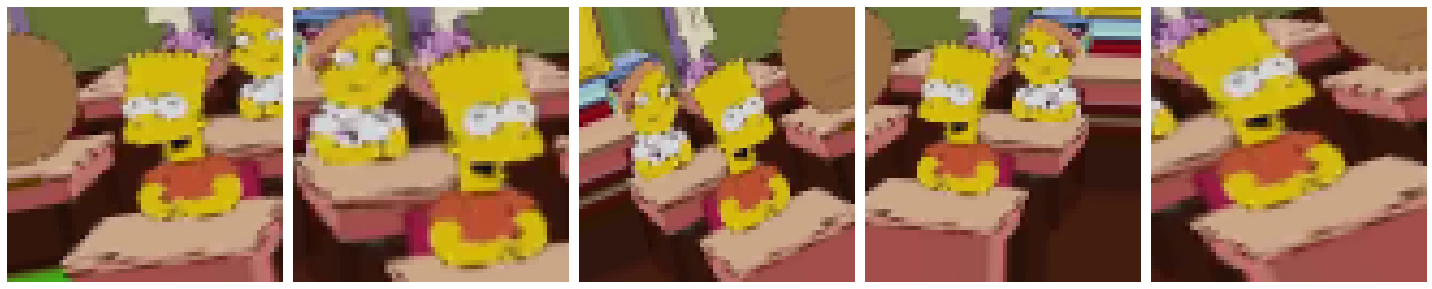

In [17]:
augmented_images = [data_train_gen[5][0][20] for i in range(5)]
plotImages(augmented_images)

#### Обучение модели

In [0]:
try:
    history = model.fit(x=data_train_gen, epochs=40, verbose=1, shuffle=True, validation_data=(X_val, y_val))
except KeyboardInterrupt:
    print('\n\nStopped')


Epoch 1/40
206/206 [==============================] - 244s 1s/step - loss: 1.1427 - accuracy: 0.5688 - val_loss: 0.7928 - val_accuracy: 0.7240
Epoch 2/40
206/206 [==============================] - 242s 1s/step - loss: 0.8459 - accuracy: 0.6973 - val_loss: 0.6041 - val_accuracy: 0.7719
Epoch 3/40
 62/206 [========>.....................] - ETA: 2:46 - loss: 0.7211 - accuracy: 0.7303

In [0]:
from sklearn.metrics import classification_report

print('\n', sklearn.metrics.classification_report(, 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')

In [0]:
y_test

NameError: ignored

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
import keras

model_new = keras.models.load_model(GLOBAL_PATH + '/data/weights.best.hdf5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [0]:
#model_new.summary()

In [0]:
model_new.fit(X_train, y_train)

ValueError: ignored

In [0]:
F = plt.figure(1, (15,20))
grid = AxesGrid(F, 111, nrows_ncols=(4, 4), axes_pad=0, label_mode="1")

for i in range(16):
    char = map_characters[i]
    image = cv2.imread(np.random.choice([k for k in glob.glob('/content/drive/My Drive/Colab Notebooks/hw/data/kaggle_simpson_testset/kaggle_simpson_testset/*.*') if char in k]))
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pic = cv2.resize(image, (64, 64)).astype('float32') / 255.
    a = model.predict(pic.reshape(1, 64, 64,3))[0]
    actual = char.split('_')[0].title()
    text = sorted(['{:s} : {:.1f}%'.format(map_characters[k].split('_')[0].title(), 100*v) for k,v in enumerate(a)], 
       key=lambda x:float(x.split(':')[1].split('%')[0]), reverse=True)[:3]
    img = cv2.resize(img, (352, 352))
    cv2.rectangle(img, (0,260),(215,352),(255,255,255), -1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Actual : %s' % actual, (10, 280), font, 0.7,(0,0,0),2,cv2.LINE_AA)
    for k, t in enumerate(text):
        cv2.putText(img, t,(10, 300+k*18), font, 0.65,(0,0,0),2,cv2.LINE_AA)
    grid[i].imshow(img)

In [0]:
plt.figure(figsize=(8,8))
cnf_matrix = sklearn.metrics.confusion_matrix(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1))
classes = list(map_characters.values())
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)